In [21]:
import pandas as pd

application_df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")

In [22]:
credit_df.isnull().sum()

,0
ID,0
MONTHS_BALANCE,0
STATUS,0


In [23]:
application_df.isnull().sum()



,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,1
NAME_HOUSING_TYPE,1


## 1. Combine Both Datasets with a meaningful way
### combine and **transform**

In [ ]:
# transform columns days_birth and days_employed
application_df['AGE_YEARS'] = round(abs(application_df['DAYS_BIRTH']) / 365, 1)
application_df['YEARS_EMPLOYED'] = round(abs(application_df['DAYS_EMPLOYED']) / 365, 1)

In [ ]:
application_df['DAYS_BIRTH'].isna().sum()

In [ ]:
# verify if there are oultiers

# Count the number of values greater than 50 in the 'YEARS_EMPLOYED' column
count_greater_than_50 = (application_df['YEARS_EMPLOYED'] > 50).sum()

print(f"Number of values greater than 50 in YEARS_EMPLOYED: {count_greater_than_50}")

In [ ]:
# manage outliers in year worked category: replace for Nan

import numpy as np

application_df['YEARS_EMPLOYED'] = np.where(
    application_df['YEARS_EMPLOYED'] > 50,  # Umbral
    np.nan,
    application_df['YEARS_EMPLOYED']
)

In [15]:
# transforming credit record (since has multiple records per id)

# calculate the worst status of historic paid for each id

# --- Define function to calculate worst payment status ---
def get_credit_status(credit_df):
    status_map = {
        'C': -1,  # Paid
        '0': 0,   # 1-29 days overdue
        '2': 2,   # 60-89 days
        '3': 3,   # 90-119 days
        '4': 4,   # 120-149 days
        '5': 5    # 150+ days or not paid
    }
    credit_df['STATUS_NUM'] = credit_df['STATUS'].map(status_map)
    worst_status = credit_df.groupby('ID')['STATUS_NUM'].max().reset_index()
    worst_status.columns = ['ID', 'WORST_STATUS']
    return worst_status

# --- Apply the function ---
credit_metrics = get_credit_status(credit_df)

# --- Merge with application data ---
merged_data = pd.merge(
    application_df,
    credit_metrics,
    on='ID',
    how='left'
)

# --- Handle missing credit history ---
merged_data['WORST_STATUS'] = merged_data['WORST_STATUS'].fillna(-2)  # -2 = No history
merged_data['HAS_CREDIT_HISTORY'] = merged_data['WORST_STATUS'].ne(-2).astype(int)


In [16]:
print(merged_data.isnull().sum())

ID                        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        1
NAME_HOUSING_TYPE         1
DAYS_BIRTH                1
DAYS_EMPLOYED             1
FLAG_MOBIL                1
FLAG_WORK_PHONE           1
FLAG_PHONE                1
FLAG_EMAIL                1
OCCUPATION_TYPE        2591
CNT_FAM_MEMBERS           1
AGE_YEARS                 1
YEARS_EMPLOYED         1537
WORST_STATUS              0
HAS_CREDIT_HISTORY        0
dtype: int64


In [20]:
merged_data['FLAG_OWN_CAR'] = merged_data['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
merged_data['FLAG_OWN_REALTY'] = merged_data['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

<ipython-input-20-df72f0fc14b3>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data['FLAG_OWN_CAR'] = merged_data['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
<ipython-input-20-df72f0fc14b3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data['FLAG_OWN_REALTY'] = merged_data['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})


In [ ]:
# replace null with category unknown
merged_data["OCCUPATION_TYPE"] = merged_data['OCCUPATION_TYPE'].fillna("Unknown")

In [ ]:
# analyze if unknown category has correlated name education, income, family status, education, own realty or age:
unknown_subset = merged_data[merged_data['OCCUPATION_TYPE'] == 'Unknown']
print(unknown_subset[["NAME_EDUCATION_TYPE", "AGE_YEARS", "AMT_INCOME_TOTAL", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "FLAG_OWN_REALTY"]].describe(include='all'))

In [ ]:

print(merged_data['OCCUPATION_TYPE'].value_counts(normalize=True))

In [17]:
# occupation type Unknown is 30% of total so I need to analyze how to fill in
# Assign Occupations Based on 3 levels:
def impute_occupation(row):
    if row['OCCUPATION_TYPE'] != 'Unknown':
        return row['OCCUPATION_TYPE']

    # Level 1: based on education + income + familiar status
    if row['NAME_EDUCATION_TYPE'] == 'Higher education':
        if row['AMT_INCOME_TOTAL'] > 200000:
            if row['NAME_FAMILY_STATUS'] in ['Married', 'Civil marriage']:
                return 'Managers'
            else:
                return 'Core Staff'  # single with high incomes but less probability to be managers

    # level 2: education + house owners
    elif row['NAME_EDUCATION_TYPE'] == 'Secondary / secondary special':
        if row['FLAG_OWN_REALTY'] == 'Y':
            return 'Laborers'
        else:
            return 'Drivers'  # example of different occupation

    # level 3: familiar status + age
    elif row['NAME_FAMILY_STATUS'] == 'Single / not married':
        if row['AGE_YEARS'] < 30:
            return 'Sales staff'
        else:
            return 'Accountants'

    # using mode for categories
    return 'Laborers'  # La ocupación más común

# 2. Aply the function
merged_data['OCCUPATION_TYPE'] = merged_data.apply(impute_occupation, axis=1)

# 3. Verify results
print(merged_data['OCCUPATION_TYPE'].value_counts(normalize=True))

OCCUPATION_TYPE
Laborers                 0.243086
Sales staff              0.153295
Core staff               0.152783
Managers                 0.116251
Drivers                  0.082281
High skill tech staff    0.061796
Medicine staff           0.041823
Accountants              0.036702
Cooking staff            0.033629
Security staff           0.024582
Cleaning staff           0.018436
Private service staff    0.012462
Secretaries              0.004609
IT staff                 0.004609
Low-skill Laborers       0.004268
Realty agents            0.004268
HR staff                 0.003414
Waiters/barmen staff     0.001707
Name: proportion, dtype: float64


Core Strategy: Jerarquía de reglas:

Primero: Educación + Ingresos + Estado Familiar

Luego: Educación + Propiedades

Después: Demografía (edad + estado civil)

Finalmente: Valor por defecto (moda)

Ventajas:

Captura relaciones complejas entre variables

Más preciso que usar una sola variable

Mantiene coherencia con el mundo real

Variables Clave Consideradas:
NAME_EDUCATION_TYPE: Principal predictor de nivel ocupacional

AMT_INCOME_TOTAL: Diferenciar roles senior/junior

NAME_FAMILY_STATUS: Solteros vs casados tienen patrones distintos

FLAG_OWN_REALTY: Indicador de estabilidad económica

AGE_YEARS: Experiencia laboral potencial

Multivariable: Combina 5 factores

Jerárquico: Decide en orden de importancia

Auditable: Cada regla tiene sentido empresarial

Menos sesgo: Evita asignar "Managers" a todos los universitarios

## 2. Give us interesting insights you could find from this dataset?
Exploratory analysis


In [18]:
# analyzing children or family member vs income amount

       AMT_INCOME_TOTAL  CNT_CHILDREN  CNT_FAM_MEMBERS
count      8.449000e+03   8449.000000      8448.000000
mean       1.940897e+05      0.397443         2.169508
std        1.108447e+05      0.693021         0.866846
min        3.330000e+04      0.000000         1.000000
25%        1.260000e+05      0.000000         2.000000
50%        1.800000e+05      0.000000         2.000000
75%        2.250000e+05      1.000000         3.000000
max        1.350000e+06      4.000000         6.000000


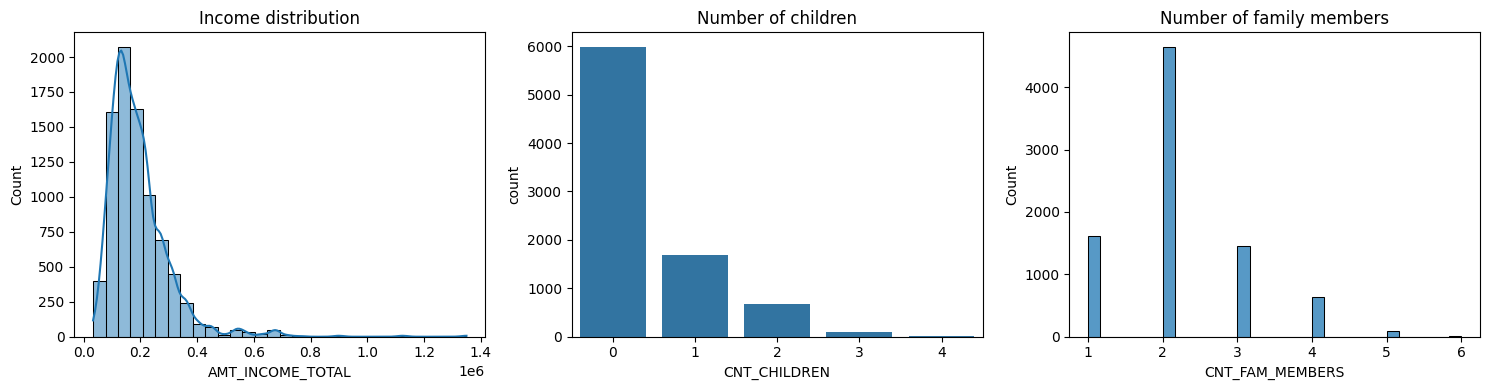

In [19]:
# Descriptive statistics
print(merged_data[['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']].describe())

import matplotlib.pyplot as plt
import seaborn as sns
# Histogramas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(merged_data['AMT_INCOME_TOTAL'], ax=axes[0], kde=True, bins=30).set_title("Income distribution")
sns.countplot(x='CNT_CHILDREN', data=merged_data, ax=axes[1]).set_title("Number of children")
sns.histplot(merged_data['CNT_FAM_MEMBERS'], ax=axes[2], bins=30).set_title("Number of family members")
plt.tight_layout()
plt.show()


In [ ]:
# Managing outliers in cnt_fam_members and cnt_childrens

merged_data["CNT_CHILDREN"].value_counts().sort_index()

In [ ]:
merged_data["CNT_FAM_MEMBERS"].value_counts().sort_index()

In [ ]:
# keeping only when children are <=5 and keeping only those rows where the family size is within the top 99%,
# removing the top 1% (most extreme and rare cases).

merged_data = merged_data[
    (merged_data["CNT_CHILDREN"] <= 5) &
    (merged_data["CNT_FAM_MEMBERS"] <= np.percentile(merged_data["CNT_FAM_MEMBERS"], 99))
]

In [ ]:
# boxplot by category

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='CNT_CHILDREN', y='AMT_INCOME_TOTAL', data=merged_data)
plt.title('Income by children numbers')
plt.show()

In [ ]:
#  quick analysys income vs delincuency
merged_data['INCOME_GROUP'] = pd.qcut(merged_data['AMT_INCOME_TOTAL'], q=5)
# print("\ndelincuency by income quintile:")
# print(merged_data.groupby('INCOME_GROUP')['WORST_STATUS'].mean().sort_values())


# 1. Filter dataset to exclude cases without hisroty (-2)
data_hist = merged_data[merged_data['WORST_STATUS'] != -2]

# 2. calculate estadistics in filtered dataset
print("\nDistribución de morosidad en casos CON historial:")
print(data_hist['WORST_STATUS'].value_counts(normalize=True).sort_index())

# 3. Analysis for quintiles of income (excluyendo -2)
print("\nMorosidad promedio por quintil de ingreso (excluyendo sin historial):")
quintiles_with_historic = data_hist.groupby('INCOME_GROUP')['WORST_STATUS'].mean().sort_values(ascending=False)
print(quintiles_with_historic)

Patrón inesperado:

Los grupos de mayores ingresos muestran mayor morosidad promedio

El quintil más rico tiene casi el doble de morosidad que el quintil bajo (0.0289 vs 0.0144)

Relación no lineal:

No existe una correlación simple "a menor ingreso, mayor morosidad"

El quintil más pobre no es el que muestra mayor morosidad

Diferencia significativa:

Hay una brecha importante entre el quintil bajo (0.0144) y los demás grupos

In [ ]:
print("\nDistribución de morosidad (WORST_STATUS):")
print(merged_data['WORST_STATUS'].value_counts(normalize=True).sort_index())

In [ ]:
# 92.45% has no credit status

# Revisar cuántos IDs únicos hay en cada dataset
print(f"IDs en application: {application_df['ID'].nunique()}")
print(f"IDs en credit: {credit_df['ID'].nunique()}")

# Verificar solapamiento
common_ids = set(application_df['ID']).intersection(set(credit_df['ID']))
print(f"IDs comunes: {len(common_ids)}")

In [ ]:
# verifico si he ehcho bien el merge
# Verifica cómo se unieron los datos
merge_info = pd.merge(
    application_df[['ID']],
    credit_df[['ID']].drop_duplicates(),
    on='ID',
    how='left',
    indicator=True
)

print(merge_info['_merge'].value_counts())

In [ ]:
# create new column to identify customer with historic data and new customers

merged_data['CLIENT_TYPE'] = np.where(
    merged_data['HAS_CREDIT_HISTORY'] == 1,
    'EXISTING',
    'NEW'
)

# quick comparative analysis
print(merged_data.groupby('CLIENT_TYPE')[['AMT_INCOME_TOTAL', 'AGE_YEARS', 'CNT_FAM_MEMBERS']].mean())

In [ ]:
# creating proxy variabe for new customers

# 1. income to expense ratio (payment capacity)
merged_data['INCOME_PER_MEMBER'] = merged_data['AMT_INCOME_TOTAL'] / merged_data['CNT_FAM_MEMBERS']

# 2. employement stability (risk proxy)
merged_data['EMPLOYMENT_STABILITY'] = merged_data['YEARS_EMPLOYED'] / merged_data['AGE_YEARS']

# 3. risk score
merged_data['RISK_SCORE'] = (
    0.4 * (merged_data['AMT_INCOME_TOTAL'] / merged_data['AMT_INCOME_TOTAL'].median()) +
    0.3 * (merged_data['AGE_YEARS'] / merged_data['AGE_YEARS'].median()) +
    0.3 * (merged_data['EMPLOYMENT_STABILITY'] / merged_data['EMPLOYMENT_STABILITY'].median())
)

In [ ]:
# incomes for client type
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=merged_data,
    x='CLIENT_TYPE',
    y='AMT_INCOME_TOTAL',
    showfliers=False
)
plt.axhline(y=merged_data['AMT_INCOME_TOTAL'].median(),
            color='red',
            linestyle='--',
            linewidth=1.5,
            label='global median')
plt.title('income distribution: new clients vs existing')
plt.show()

# risk for occupation (new clients only)
plt.figure(figsize=(18, 6))
sns.boxplot(
    data=merged_data[merged_data['CLIENT_TYPE'] == 'NEW'],
    x='OCCUPATION_TYPE',
    y='RISK_SCORE',
    showfliers=False
)
plt.xticks(
    rotation=45,
    ha='right',
    fontsize=10
)
plt.yticks(fontsize=10)
plt.title('distribution of the risk score for occupation (new clients)', fontsize=14, pad=20)
plt.xlabel('occupation type', fontsize=12, labelpad=10)
plt.ylabel('risk score', fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()

Unexpected Pattern: Higher-income groups show higher average delinquency.

The richest quintile has almost twice the delinquency rate of the lowest quintile (0.0289 vs 0.0144).

Non-linear Relationship: There is no simple correlation like "lower income, higher delinquency."

The poorest quintile is not the one with the highest delinquency.

Significant Difference:

There is a notable gap between the lowest quintile (0.0144) and the other groups.

In [ ]:
# risk for occupation ( clients with historic data only)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1],  # <-- key filter
    x='OCCUPATION_TYPE',
    y='WORST_STATUS',
    estimator=lambda x: (x >= 2).mean() * 100,  # % high delicnuency
    palette="RdYlGn_r"  # Red (high risk) -> Green (low risk)
)
plt.xticks(rotation=45, ha='right')
plt.title("% Morosidad Grave por Ocupación (Clientes con Historial)", fontsize=14)
plt.ylabel("% Morosidad (60+ días atraso)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Interpretation
High values (longer bars) = Higher percentage of delinquent customers in that occupation.

Low values (shorter bars) = Lower delinquency rate.

Color palette (RdYlGn_r):

Red → Higher risk (more delinquency)

Green → Lower risk (less delinquency)
(The _r suffix means the palette is reversed from its default order.)

Why some red bars might be shorter:
This happens when an occupation has:

Few cases (small sample size) but a high delinquency rate (hence the red color).

Compared to occupations with:

Many more cases (longer bars) but a lower delinquency rate (green).





In [ ]:


#delete flag mobil as is irrilevant
merged_data.drop('FLAG_MOBIL', axis=1, inplace=True)

# 1. correlation between numeric variables
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data.select_dtypes(include=['number']).corr(),
            annot=True,
            cmap='coolwarm',
            fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

# 2. distribution by age for client type
sns.displot(data=merged_data,
            x='AGE_YEARS',
            hue='CLIENT_TYPE',
            kind='kde',
            height=6,
            aspect=1.5)
plt.title('Distribución de Edades')
plt.show()

In [ ]:
correlation_matrix = merged_data.select_dtypes(include=['number']).corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

# 3. Suggest whom should get credit card and how to decrease the risk?

In [ ]:
# creating new df for client with historic data only

df_hist = merged_data[merged_data['WORST_STATUS'] != -2].copy()

In [ ]:
# creating binary target: 0 good payer, 1 bad payer

df_hist['target'] = df_hist['WORST_STATUS'].apply(lambda x: 1 if x >= 2 else 0)


In [ ]:
df_hist['target'].value_counts()


In [ ]:
# groups are unbalanced so I will proceed with an hybrid approach to define the target

# Define target
merged_data['TARGET'] = np.where(
    merged_data['HAS_CREDIT_HISTORY'] == 1,
    (merged_data['WORST_STATUS'] >= 2).astype(int),  # Clientes existentes
    (merged_data['RISK_SCORE'] > merged_data['RISK_SCORE'].quantile(0.75)).astype(int)  # Clientes nuevos
)

# Verify distribution
print(merged_data['TARGET'].value_counts(normalize=True))


#### *1.Definition of the Target (Objective Variable)
Hybrid Approach (Combines the best of the two options we discussed):

For clients with credit history (EXISTING):

TARGET = 1 if WORST_STATUS ≥ 2 (serious delinquency → DO NOT approve).

TARGET = 0 if WORST_STATUS < 2 (good payer → APPROVE).

For new clients (NEW):

Use your RISK_SCORE to define a risk threshold:

If RISK_SCORE > 75th percentile → TARGET = 1 (high risk → DO NOT approve).

If RISK_SCORE ≤ 75th percentile → TARGET = 0 (acceptable risk → APPROVE).

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 1. Define variables
numeric_features = ['AGE_YEARS', 'AMT_INCOME_TOTAL', 'INCOME_PER_MEMBER', 'EMPLOYMENT_STABILITY']
categorical_features = ['OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE']

In [ ]:
# 2. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# 3. Pipeline complete
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',  # Maneja desbalance
        random_state=42
    ))
])

In [ ]:
# 4. Train (only with existing clients)
X_train = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1][numeric_features + categorical_features]
y_train = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1]['TARGET']
model.fit(X_train, y_train)

In [ ]:
missing_info = merged_data[numeric_features + categorical_features].isnull().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)

print("Clumns with missing values:")
print(missing_info)

In [ ]:
total_rows = merged_data.shape[0]
faltantes = merged_data['EMPLOYMENT_STABILITY'].isnull().sum()
print(f"Faltan {faltantes} valores ({faltantes / total_rows:.2%})")

In [ ]:
merged_data[merged_data['EMPLOYMENT_STABILITY'].isnull()]['HAS_CREDIT_HISTORY'].value_counts()


In [ ]:
X_train.isnull().sum()

In [ ]:
merged_data['EMPLOYMENT_STABILITY'] = merged_data['EMPLOYMENT_STABILITY'].fillna(0)
# Business logic: A 0 in job stability indicates individuals with no experience or recently hired.


In [ ]:
# 4. Train (only with existing clients)
X_train = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1][numeric_features + categorical_features]
y_train = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1]['TARGET']
model.fit(X_train, y_train)

In [ ]:
print(merged_data['DAYS_BIRTH'].isnull().sum())

In [ ]:
# preprocessing data for new clients (same features)
X_new = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 0][numeric_features + categorical_features]

# Predict risk probabilities (adjust threshold later)
new_clients_proba = model.predict_proba(X_new)[:, 1]  # Probabilidad de ser moroso (clase 1)

In [ ]:
# EVALUATION OF MY MODEL
#  1. split into test y train

from sklearn.metrics import classification_report, roc_auc_score

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1][numeric_features + categorical_features],
    merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1]['TARGET'],
    test_size=0.3,
    stratify=merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1]['TARGET'],
    random_state=42
)



In [ ]:
# 2. training and evaluate

# Adjust class_weight and train (the classes are highly imbalanced for direct training)

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Define variables
numeric_features = ['AGE_YEARS', 'AMT_INCOME_TOTAL', 'INCOME_PER_MEMBER', 'EMPLOYMENT_STABILITY','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categorical_features = ['OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE']

# 2. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 3. Crear pipeline with class_weight adjusted
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight={0: 1, 1: 10},  # Aumentamos la penalización a clase minoritaria
        random_state=42
    ))
])

# 4. Train model
X_train = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1][numeric_features + categorical_features]
y_train = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1]['TARGET']
model.fit(X_train, y_train)


In [ ]:
# validate

X_test = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1][numeric_features + categorical_features].sample(10000, random_state=42)
y_test = merged_data.loc[X_test.index, 'TARGET']

# Predect probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
#search for best threesold

from sklearn.metrics import precision_recall_curve, classification_report

# search thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# threesold with recall >= 0.7 and best precision
candidates = [(p, r, t) for p, r, t in zip(precisions, recalls, thresholds) if r >= 0.7]
if candidates:
    best = max(candidates, key=lambda x: x[0])  # best precision with recall >= 0.7
    best_precision, best_recall, best_threshold = best
    print(f"Umbral óptimo: {best_threshold:.3f} | Precision: {best_precision:.2f} | Recall: {best_recall:.2f}")
else:
    print("No se encontró umbral con recall >= 0.7")

# Re-predect with this threesold
y_pred_optimal = (y_proba >= best_threshold).astype(int)

# see result
print(classification_report(y_test, y_pred_optimal))

Precision: For class 1 (clients who are approved for the card), you have a precision of 0.63, which means that 63% of the clients your model classified as approved actually should have been approved. This is reasonable for an imbalanced case, where only 1.9% of the samples belong to class 1.

Recall: A recall of 0.71 for class 1 means that 71% of the clients who truly should have been approved were correctly identified by the model. This is a good recall, since the positive class is small and it's important not to miss good candidates.

F1-Score: The F1 score of 0.67 is a combination of precision and recall for class 1, which is quite good—especially in imbalanced contexts.

Accuracy: The overall accuracy is 0.99, indicating that the model is correct in most predictions. However, this metric isn't always meaningful in imbalanced situations, as it can be biased toward the majority class (0 in this case). Despite this, the strong recall and precision for class 1 suggest the model is performing well.

Macro average: A precision of 0.81 and recall of 0.85 reflect overall performance across both classes. For a model dealing with significant imbalance, these values are quite positive.

Weighted average: The 0.99 metrics show that the model performs extremely well for the majority class (almost perfectly), as expected, but also indicate that it’s not neglecting the minority class (1).

In [ ]:
# Cross-validation to ensure the results hold across different splits.

# 1. StratifiedKFold to ensure a similar proportion of class 0 and 1 in each fold.

# 2. cross_validate to compute multiple metrics (precision, recall, f1).

# 3. Use the same pipeline (model) you already have, with adjusted class_weight..

from sklearn.model_selection import StratifiedKFold, cross_validate

# 1. Data
X = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1][numeric_features + categorical_features]
y = merged_data[merged_data['HAS_CREDIT_HISTORY'] == 1]['TARGET']

# 2. Stratified cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Execute cross validation
scoring = ['precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

# 4. Results
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")

In [ ]:
# Algorithm for new clients

In [ ]:
def approve_credit(client_data, model, preprocessor):
    """
    Versión corregida que selecciona solo las features necesarias
    """
    try:
        # 1. Select only the features expected by the model
        required_features = numeric_features + categorical_features
        client_data_subset = client_data[required_features].copy()

        # 2. Validate that no features are missings
        missing_features = set(required_features) - set(client_data.columns)
        if missing_features:
            raise ValueError(f"Faltan features requeridas: {missing_features}")

        # 3. Preprocessing and prediction
        client_processed = preprocessor.transform(client_data_subset)
        proba = model.predict_proba(client_processed)[0, 1]

        # 4. Make a decision
        decision = "REJECT" if proba >= FINAL_THRESHOLD else "APPROVE"

        return {
            "decision": decision,
            "risk_probability": float(round(proba, 4)),
            "threshold": float(FINAL_THRESHOLD),
            "used_features": required_features
        }

    except Exception as e:
        return {
            "error": str(e),
            "decision": "MANUAL_REVIEW",
            "details": "Processing error – manual review required"
        }

# Correct usage example:
Assuming that raw_client_data is a DataFrame with all your fields:

Create a DataFrame with only the necessary features

client_sample = raw_client_data.iloc[[0]][numeric_features + categorical_features]


Call the function

result = approve_credit(client_sample, model, preprocessor)
print(result)
